Kristjn Eljand, Martin Laid, Jean-Baptiste Scellier, Sohier Dane, Maggie Demkin, Addison Howard. (2023). Enefit - Predict Energy Behavior of Prosumers. Kaggle. [Enefit - Predict Energy Behavior of Prosumers](https://www.kaggle.com/competitions/predict-energy-behavior-of-prosumers/overview)

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sea

In [ ]:
pd.set_option('display.max_columns', 100)
sea.set_context('notebook')
sea.set_style("whitegrid")

In [ ]:
root = os.getcwd()

data        = pd.read_csv(os.path.join(root, "train.csv"), low_memory=False)
client      = pd.read_csv(os.path.join(root, "client.csv"), low_memory=False)
gas         = pd.read_csv(os.path.join(root, "gas_prices.csv"), low_memory=False)
electricity = pd.read_csv(os.path.join(root, "electricity_prices.csv"), low_memory=False)
forecast    = pd.read_csv(os.path.join(root, "forecast_weather.csv"), low_memory=False)
historical  = pd.read_csv(os.path.join(root, "historical_weather.csv"), low_memory=False)
location    = pd.read_csv(os.path.join(root, "weather_station_to_county_mapping.csv"), low_memory=False)

# Data type manipiulation
data['hour']        = pd.to_datetime(data['datetime']).dt.hour
data['date']        = pd.to_datetime(data['datetime']).dt.date
client['hour']      = pd.to_datetime(client['date']).dt.hour
client['date']      = pd.to_datetime(client['date']).dt.date
gas['hour']         = pd.to_datetime(gas['forecast_date']).dt.hour
gas['date']         = pd.to_datetime(gas['forecast_date']).dt.date
electricity['hour'] = pd.to_datetime(electricity['forecast_date']).dt.hour
electricity['date'] = pd.to_datetime(electricity['forecast_date']).dt.date
forecast['hour']    = pd.to_datetime(forecast['forecast_datetime']).dt.tz_convert('UTC').dt.hour
forecast['date']    = pd.to_datetime(forecast['forecast_datetime']).dt.tz_convert('UTC').dt.date
historical['hour']  = pd.to_datetime(historical['datetime']).dt.hour
historical['date']  = pd.to_datetime(historical['datetime']).dt.date
forecast['date']    = pd.to_datetime(forecast['forecast_datetime']).dt.tz_convert('UTC').dt.date

## train.csv

In [ ]:
data.isnull().sum()

county                  0
is_business             0
product_type            0
target                528
is_consumption          0
datetime                0
data_block_id           0
row_id                  0
prediction_unit_id      0
hour                    0
date                    0
dtype: int64

In [ ]:
# 528 out of 2018352 is contemptible
data.dropna(inplace=True)

# Merge

In [ ]:
df0 = data.merge(client.drop('data_block_id', axis=1), on=['county', 'is_business', 'product_type', 'date', 'hour'], how="left")
df1 = df0.merge(gas.loc[:, ['date', 'lowest_price_per_mwh', 'highest_price_per_mwh']], on='date', how='left')
df2 = df1.merge(electricity.loc[:, ['euros_per_mwh', 'date', 'hour']], on=['date', 'hour'], how="left")

forecast_location   = forecast.merge(location, on=['longitude', 'latitude'], how="left")
forecast_location.drop(['forecast_datetime', 'origin_datetime', 'county_name', 'data_block_id'], axis=1, inplace=True)

temp = forecast_location.groupby(['date', 'county']).mean()
df3 = df2.merge(temp,  on=['date', 'county'], how="left", suffixes=('', '_y'))
df3.drop('hour_y', axis=1, inplace=True)


historical_location = historical.merge(location, on=['longitude', 'latitude'], how="left")
historical_location.drop(['datetime', 'longitude', 'latitude', 'county_name', 'data_block_id'], axis=1, inplace=True)

temp = historical_location.groupby(['hour', 'date', 'county']).mean()
df4 = df3.merge(temp,  on=['date', 'hour', 'county'], how="left", suffixes=('', '_hist'))

df4['datetime'] = pd.to_datetime(df4['datetime'])
original_datetime = df4['datetime']
revealed_targets = df4[['datetime', 'prediction_unit_id', 'is_consumption', 'target']].copy()
n_days_lags = 7
for day_lag in range(2, n_days_lags+1):
  revealed_targets['datetime'] = original_datetime + pd.DateOffset(day_lag)
  df = df.merge(revealed_targets, how='left',
                    on = ['datetime', 'prediction_unit_id', 'is_consumption'],
                    suffixes = ('', f'_{day_lag}_days_ago'))

df = df[df['target'].notnull()]
df4.set_index('row_id', inplace=True)

df = df4.copy()
df['year'] = pd.to_datetime(data['datetime']).dt.year
df['month'] = pd.to_datetime(data['datetime']).dt.month
df['week'] = pd.to_datetime(data['datetime']).dt.isocalendar().week
df['day'] = pd.to_datetime(data['datetime']).dt.day

In [ ]:
df.to_csv('df.csv')

## Explore dataset

In [2]:
df = pd.read_csv('df.csv')

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40522 entries, 434 to 41259
Data columns (total 61 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   row_id                             40522 non-null  int64         
 1   county                             40522 non-null  int64         
 2   is_business                        40522 non-null  int64         
 3   product_type                       40522 non-null  int64         
 4   target                             40522 non-null  float64       
 5   is_consumption                     40522 non-null  int64         
 6   datetime                           40522 non-null  datetime64[ns]
 7   data_block_id                      40522 non-null  int64         
 8   prediction_unit_id                 40522 non-null  int64         
 9   hour                               40522 non-null  int64         
 10  date                            

In [4]:
df.isna().sum()

row_id                               0
county                               0
is_business                          0
product_type                         0
target                               0
is_consumption                       0
datetime                             0
data_block_id                        0
prediction_unit_id                   0
hour                                 0
date                                 0
eic_count                            0
installed_capacity                   0
lowest_price_per_mwh                 0
highest_price_per_mwh                0
euros_per_mwh                        0
latitude                             0
longitude                            0
hours_ahead                          0
temperature                          0
dewpoint                             0
cloudcover_high                      0
cloudcover_low                       0
cloudcover_mid                       0
cloudcover_total                     0
10_metre_u_wind_component

In [7]:
df.dtypes

row_id                                 int64
county                                 int64
is_business                            int64
product_type                           int64
target                               float64
is_consumption                         int64
datetime                              object
data_block_id                          int64
prediction_unit_id                     int64
hour                                   int64
date                                  object
eic_count                            float64
installed_capacity                   float64
lowest_price_per_mwh                 float64
highest_price_per_mwh                float64
euros_per_mwh                        float64
latitude                             float64
longitude                            float64
hours_ahead                          float64
temperature                          float64
dewpoint                             float64
cloudcover_high                      float64
cloudcover

In [ ]:
y = df['target']
X = df.drop(['target'], axis=1)

<Axes: xlabel='dewpoint', ylabel='target'>

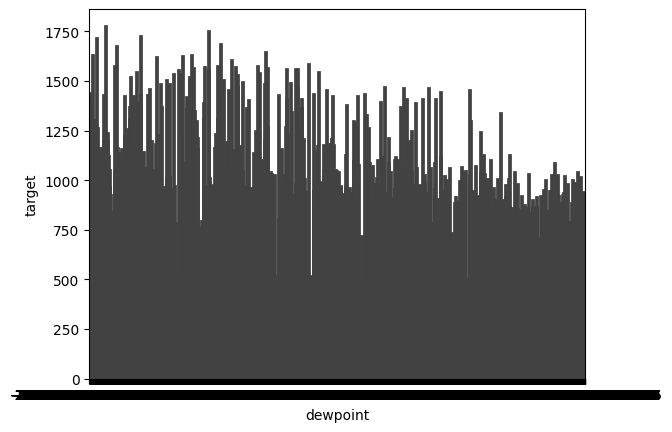

In [ ]:
sea.barplot(x=df['dewpoint'], y=df['target'])

<Axes: xlabel='month', ylabel='target'>

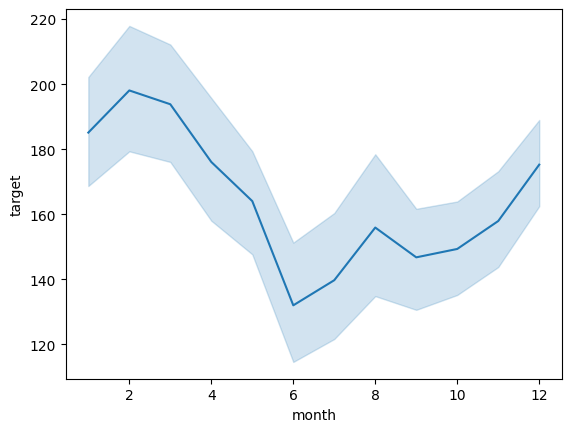

In [ ]:
sea.lineplot(data=df, x='month', y='target')

In [ ]:
axs =df.plot(y='target', x='temperature', figsize=(12, 10), subplots=True, stacked=False, kind='bar')

Error in callback <function flush_figures at 0x000002458507B920> (for post_execute):


KeyboardInterrupt: 

In [ ]:
fig, axes = plt.subplots(7, 7, figsize=(20, 20))
aux = pd.DataFrame()
for ax, feature in zip(np.array(axes).flatten(), list(X.columns)):
    if str(df[feature])=="dtype('O')":
        sea.lineplot(data=df, x='month', y='target', ax=ax)
    sea.histplot(data=df, x=feature, y=y, ax=ax)
fig.show()

C:\Users\Eduardo\AppData\Local\Temp\ipykernel_2140\67417667.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Error in callback <function _draw_all_if_interactive at 0x00000245ED0B0EA0> (for post_execute):


TypeError: Cannot cast array data from dtype('O') to dtype('float64') according to the rule 'safe'

TypeError: Cannot cast array data from dtype('O') to dtype('float64') according to the rule 'safe'

<Figure size 2000x2000 with 49 Axes>